In [0]:
import pandas as pd
import numpy as np

In [0]:
!pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 55kB/s 
     |████████████████████████████████| 450kB 43.3MB/s 
     |████████████████████████████████| 3.8MB 60.8MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 2.0.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import pandas as pd
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(16.0,4.0)

In [0]:
h5f=h5py.File(r'SVHN_single_grey1-2.h5')

In [0]:
ls=list(h5f.keys())

In [0]:
ls

['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']

In [0]:
X_train=h5f['X_train'][:]
y_train=h5f['y_train'][:]
X_test=h5f['X_test'][:]
y_test=h5f['y_test'][:]
X_val=h5f['X_val'][:]
y_val=h5f['y_val'][:]

In [0]:
X_train.shape

(42000, 32, 32)

In [0]:
y_train.shape

(42000,)

In [0]:
X_test.shape

(18000, 32, 32)

In [0]:
y_test.shape

(18000,)

In [0]:
X_val.shape

(60000, 32, 32)

In [0]:
y_val.shape

(60000,)

In [0]:
X_train = X_train.reshape(42000,1024)
print (X_train.shape)
X_test= X_test.reshape(18000, 1024)
print (X_test.shape)
X_val= X_val.reshape(60000,1024)
print (X_val.shape)

(42000, 1024)
(18000, 1024)
(60000, 1024)


In [0]:
X_train =X_train / 255.0
X_test=X_test / 255.0
X_val=X_val/255.0

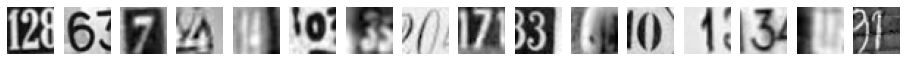

label for each of the above image: [2 6 7 4 4 0 3 0 7 3 1 0 1 3 1 1]


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(16.0,4.0)
#plt.figure(figsize=(10, 1))
for i in range(16):
    plt.subplot(1, 16, i+1)
    plt.imshow(X_train[i].reshape(32,32), cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:16]))

In [0]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

In [0]:
class NN():
    def __init__(self, lossfunc=CrossEntropy(), mode='train'):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        self.mode = mode
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)  + ((Lambda / (2 * y.shape[0])) * np.sum([np.sum(w**2) for w in self.params[0][0]]))
        nextgrad = self.loss_func.backward(out,y) + ((Lambda/y.shape[0]) * np.sum([np.sum(w) for w in self.params[0][0]]))
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        p = softmax(X)
        return np.argmax(p, axis=1)
    
    def predict_scores(self, X):
        X = self.forward(X)
        p = softmax(X)
        return p
    
    def clear_grad_param(self):
        self.grads = []

In [0]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [0]:
def update(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = (mu * v[i]) - (learning_rate * g[i])
            p[i] += v[i]

In [0]:
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]

        minibatches.append((X_batch, y_batch))
    return minibatches

In [0]:
from random import shuffle


## input size
input_dim = X_train.shape[1]

def train_and_test_loop(iterations, lr, Lambda, verb=True):
    ## hyperparameters
    iterations = iterations
    learning_rate = lr
    hidden_nodes = 10
    output_nodes = 10

    ## define neural net
    nn = NN()
    nn.add_layer(Linear(input_dim, hidden_nodes))

    nn, val_acc = sgd(nn, X_train , y_train, minibatch_size=1000, epoch=iterations, learning_rate=learning_rate,\
                      X_val=X_val, y_val=y_val, Lambda=Lambda, verb=verb)
    return val_acc

In [0]:
import numpy as np 

class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, X):
        self.X = X
        output = np.dot(self.X, self.W) + self.b
        return output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

In [0]:
def sgd(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None, Lambda=0, verb=True):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)
    
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = []
        y_val_pred = []
        y_train1 = []
        y_vall = []
        for ii in range(0, m_train, minibatch_size):
            X_tr = X_train[ii:ii + minibatch_size, : ]
            y_tr = y_train[ii:ii + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for ii in range(0, m_val, minibatch_size):
            X_va = X_val[ii:ii + minibatch_size, : ]
            y_va = y_val[ii:ii + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)
        
        ## weights
        w = np.array(net.params[0][0])
        
        ## adding regularization to cost
        mean_train_loss = (sum(loss_batch) / float(len(loss_batch)))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        if verb:
            if i%50==0:
                print("Epoch {3}/{4}: Loss = {0} | Training Accuracy = {1}".format(mean_train_loss, train_acc, val_acc, i, epoch))
    return net, val_acc

In [0]:
def check_accuracy(y_true, y_pred):
    count = 0
    for i,j in zip(y_true, y_pred):
        if int(i)==j:
            count +=1
    return float(count)/float(len(y_true))

In [0]:
lr = 0.00001
Lambda = 1e3
train_and_test_loop(1, lr, Lambda)

Epoch 0/1: Loss = 2.319596991658482e+127 | Training Accuracy = 0.09966666666666667


0.1

In [94]:
lr = 1e-7
Lambda = 1e-7
train_and_test_loop(500, lr, Lambda)

Epoch 0/500: Loss = 2.3138962675322463 | Training Accuracy = 0.09738095238095239
Epoch 50/500: Loss = 2.3130833581680483 | Training Accuracy = 0.09785714285714285
Epoch 100/500: Loss = 2.312330333515674 | Training Accuracy = 0.09807142857142857
Epoch 150/500: Loss = 2.311632570266614 | Training Accuracy = 0.09833333333333333
Epoch 200/500: Loss = 2.310985829431664 | Training Accuracy = 0.09869047619047619
Epoch 250/500: Loss = 2.310386220795151 | Training Accuracy = 0.0989047619047619
Epoch 300/500: Loss = 2.3098301710961664 | Training Accuracy = 0.09885714285714285
Epoch 350/500: Loss = 2.309314395496248 | Training Accuracy = 0.09895238095238096
Epoch 400/500: Loss = 2.3088358719504667 | Training Accuracy = 0.09888095238095237
Epoch 450/500: Loss = 2.3083918181482552 | Training Accuracy = 0.0990952380952381


0.09946666666666666

In [0]:
import math
for k in range(1,100):
    lr = math.pow(10, np.random.uniform(-7.0, 4.0))
    Lambda = math.pow(10, np.random.uniform(-5,5))
    best_acc = train_and_test_loop(100, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Try 1/100: Best_val_acc: 0.16871666666666665, lr: 0.0002662506185368314, Lambda: 0.00044091195095033865

Try 2/100: Best_val_acc: 0.09258333333333334, lr: 3.1793195438635184e-06, Lambda: 1.1402804526713861

Try 3/100: Best_val_acc: 0.0999, lr: 4.7189852682104045e-07, Lambda: 19.663845005648167

Try 4/100: Best_val_acc: 0.10611666666666666, lr: 2.845701475594959, Lambda: 0.0001438760358263015



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Try 5/100: Best_val_acc: 0.1, lr: 4.989560851329813, Lambda: 793.681762297938



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in add
  


In [0]:
#With Learning rate=4.71 and lambda =19.66 we can get best validatio accuracy of 0.099